# Plot regions used in the study and table of available dataset/models per parameter

In [1]:
from trends_functions import *
from warnings import filterwarnings
import pandas as pd
import matplotlib.patheffects as PathEffects
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely.geometry.polygon import LinearRing
filterwarnings('ignore')

In [2]:
# import seaborn style
sns.set()
sns.set_context("paper")
# sns.set_style("whitegrid")
sns.color_palette("muted")
# since each figure will be a subfigure, increase font_size
fscale = 1.0
sns.set(font_scale=fscale)

### start with regions map

In [3]:
regions = get_regions()

In [11]:
parameters = ['od550aer', 'concpm10', 'concso4', 'scatc550dryaer', 'absc550aer']
#parameters = []

In [12]:
#read observations
OBS_MAP, OBS_DF = {}, {}

for i, var in enumerate(parameters):
    # computation parameters
    params = get_params()
    params['kind'] = 'obs'
    fill_params(params, var)

    params['var'] = var
    obs_source = params['source']
    reader = pya.io.ReadUngridded(obs_source)
    obs_data = reader.read(vars_to_retrieve=var)
    
    #compte the trend just to have filtering (300 points, ...)
    _, OBS_MAP[var], OBS_DF[var] = process_trend(
        obs_data, params,
        plot=False, show_plot=False, save_plot=False, write_json=False
    )

no flags
no flags EUROPE station:  ZvenigoroddsEi_GCWD EUROPE station:  Palaiseau
no flags ASIA station:  Zhongshan_UnivityDh ASIA station:  Liangning
no flags NAMERICA station:  Yumaowknife_AuroraC NAMERICA station:  DRAGON_Parlier NAMERICA station:  NEON_BONA
no flags SAMERICA station:  Veracruz_MAX_MEXFOP
no flags NAFRICA station:  Zinder_DMNporttutea
region:  SAFRICA station:  Walvis_Bay_airport
Less than 7 points in selected period
no flags
no flags AUSTRALIA station:  Tinga_Tinganand_QLD
region:  ASIA station:  Petalling Jayalandntésertrch Observatorytcagni
Less than 7 points in selected period
No station found in , SAFRICArraablo de los MontesCyprus Atmospheric Observatory
No station found in , AUSTRALIA
no flags WORLD station:  Zosenibodenntainstional Park-Lind Point (VI01)n5)tory
no flags EUROPE station:  Ähtäri I-III Dam)
no flags ASIA station:  TereljRataari (Vachiralongkorn Dam)
no flags NAMERICA station:  Zion_Canyon - Turtleback Domey_Run)
no flags SAMERICA station:  Virg

In [14]:
thead = ['Region', 'Lat [Min-Max]', 'Lon [Min-Max]']
tbody = []
for region in regions:
    pyreg = pya.Region(region)
    tbody.append([pyreg.name, pyreg['lat_range'], pyreg['lon_range']])
df = pd.DataFrame(tbody,columns=thead)

In [15]:
df

,Region,Lat [Min-Max],Lon [Min-Max]
0,EUROPE,"[40, 72]","[-10, 40]"
1,ASIA,"[0, 72]","[50, 150]"
2,NAMERICA,"[20, 80]","[-150, -45]"
3,SAMERICA,"[-60, 20]","[-105, -30]"
4,NAFRICA,"[0, 40]","[-17, 50]"
5,SAFRICA,"[-35, 0]","[10, 40]"
6,AUSTRALIA,"[-50, -10]","[110, 155]"
7,WORLD,"[-90, 90]","[-180, 180]"


<Figure size 691.2x388.8 with 0 Axes>

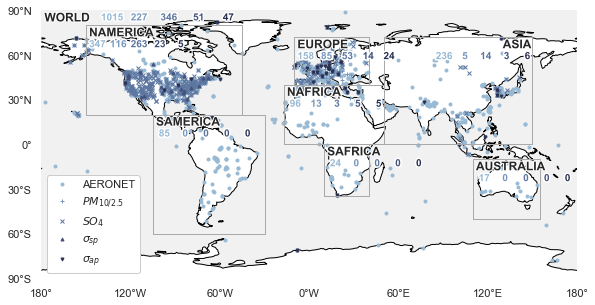

In [19]:
#map WITHOUT 300 days criteria
nl, nc = 1, 1
fs = 0.6
fig = plt.figure(figsize=(16*fs,9*fs))
fig, ax = plt.subplots(1, 1,
                       subplot_kw=dict(projection=ccrs.PlateCarree()),
                       )
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, facecolor='#f1f1f1', alpha=0)
ax.add_feature(cartopy.feature.OCEAN, facecolor='#f1f1f1', alpha=1)

#plot the regions
for region in regions:
    pyreg = pya.Region(region)
    
    reglons = pyreg['lon_range']
    reglats = pyreg['lat_range']
    
    #get rectangle coordinates
    lons = [reglons[0], reglons[0], reglons[1], reglons[1]]
    lats = [reglats[0], reglats[1], reglats[1], reglats[0]]
    ring = LinearRing(list(zip(lons, lats)))
    if region!='WORLD':
        ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='darkgray', zorder=50)
    if region=='ASIA':
        x0, y0 = reglons[1]-20, reglats[1]-2
    else:
        x0, y0 = reglons[0]+2, reglats[1]-2
    txt = ax.text(x0, y0, pyreg['_name'], ha='left', va='top', fontweight='bold', zorder=60)
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

#plot the observations available
palette = sns.cubehelix_palette(len(parameters), start=0, rot=-.15, dark=.2, light=.7, reverse=False)
#palette = sns.light_palette("navy", reverse=False)
#palette = sns.color_palette("Blues", n_colors=len(parameters))
#palette = list(reversed(['#2d3d60','#150578','#192bc2','#449dd1','#78c0e0']))
#palette = sns.color_palette('Set2')
#palette = ['#a6cee3','#1f78b4','#fb9a99','#b2df8a','#33a02c']
#palette = sns.color_palette('deep')
#palette = [palette[i] for i in [7,2,3,9,0]]

#palette = sns.color_palette("pastel")
#parameters = ['od550aer', 'concpm10', 'concso4', 'scatc550dryaer', 'absc550aer']
networks = ['AERONET', '$PM_{10/2.5}$', '$SO_{4}$', '$\sigma_{sp}$', '$\sigma_{ap}$']
colors = [palette[i] for i, var in enumerate(parameters)]
markers = ['o', '+', 'x','^', 'v']
sizes = [3, 4, 4, 3, 3]
for i, var in enumerate(parameters):
    #stations include all the stations, while the keys include the stations used in the regional time series
    stations = OBS_MAP[var]['WORLD']['stations']
    keys = list(OBS_DF[var]['WORLD'].keys())

    lons = [station['lon'] for station in OBS_MAP[var]['WORLD']['stations']]
    lats = [station['lat'] for station in OBS_MAP[var]['WORLD']['stations']]
    ax.plot(lons, lats, marker=markers[i], lw=0, ms=sizes[i], color=colors[i], alpha=1, transform=ccrs.PlateCarree(), label=networks[i] )
    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    #add nmax
    for region in regions:
        pyreg = pya.Region(region)
        reglons = pyreg['lon_range']
        reglats = pyreg['lat_range']
        y0 = reglats[1]-2
        if region=='WORLD':
            x0 = reglons[0]+40
            dx = 20
            dy = 0
        else:
            x0 = reglons[0]+2
            dx=14
            dy = 8
        if region=='ASIA':
            x0 = reglons[1]-65
        if region in OBS_MAP[var]:
            nmax = len(list(OBS_MAP[var][region]['stations']))
        else:
            nmax = 0
        txt = ax.text(x0+i*dx, y0-dy, '{:3d}'.format(nmax), ha='left', va='top', fontweight='bold', fontsize=10, color=colors[i],zorder=80, backgroundcolor=(1,1,1,.0))
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        
plt.legend(fancybox=True,framealpha=1, shadow=False, facecolor='white')
ax.outline_patch.set_visible(False)
ax.outline_patch.set_linewidth(0)

plt.grid(False)
plt.box(None)
fig.set_size_inches(16*fs,9*fs)
plt.savefig('figs/maps/av_obs.png', dpi=300, bbox_inches='tight')

In [18]:
nl, nc = 1, 1
fs = 0.6
fig = plt.figure(figsize=(16*fs,9*fs))
fig, ax = plt.subplots(1, 1,
                       subplot_kw=dict(projection=ccrs.PlateCarree()),
                       )
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, facecolor='#f1f1f1', alpha=0)
ax.add_feature(cartopy.feature.OCEAN, facecolor='#f1f1f1', alpha=1)

#plot the regions
for region in regions:
    pyreg = pya.Region(region)
    
    reglons = pyreg['lon_range']
    reglats = pyreg['lat_range']
    
    #get rectangle coordinates
    lons = [reglons[0], reglons[0], reglons[1], reglons[1]]
    lats = [reglats[0], reglats[1], reglats[1], reglats[0]]
    ring = LinearRing(list(zip(lons, lats)))
    if region!='WORLD':
        ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='darkgray', zorder=50)
    if region=='ASIA':
        x0, y0 = reglons[1]-20, reglats[1]-2
    else:
        x0, y0 = reglons[0]+2, reglats[1]-2
    txt = ax.text(x0, y0, pyreg['_name'], ha='left', va='top', fontweight='bold', zorder=60)
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

#plot the observations available
palette = sns.cubehelix_palette(len(parameters), start=0, rot=-.15, dark=.2, light=.7, reverse=False)
#palette = sns.light_palette("navy", reverse=False)
#palette = sns.color_palette("Blues", n_colors=len(parameters))
#palette = list(reversed(['#2d3d60','#150578','#192bc2','#449dd1','#78c0e0']))
#palette = sns.color_palette('Set2')
#palette = ['#a6cee3','#1f78b4','#fb9a99','#b2df8a','#33a02c']
#palette = sns.color_palette('deep')
#palette = [palette[i] for i in [7,2,3,9,0]]

#palette = sns.color_palette("pastel")
#parameters = ['od550aer', 'concpm10', 'concso4', 'scatc550dryaer', 'absc550aer']
networks = ['AERONET', '$PM_{10/2.5}$', '$SO_{4}$', 'Scat. Coef.', 'Abs. Coef']
colors = [palette[i] for i, var in enumerate(parameters)]
markers = ['o', '+', 'x','^', 'v']
sizes = [3, 4, 4, 3, 3]
for i, var in enumerate(parameters):
    #stations include all the stations, while the keys include the stations used in the regional time series
    stations = OBS_MAP[var]['WORLD']['stations']
    keys = list(OBS_DF[var]['WORLD'].keys())

    lons = [station['lon'] for station in OBS_MAP[var]['WORLD']['stations'] if var+'_'+station['name'] in keys]
    lats = [station['lat'] for station in OBS_MAP[var]['WORLD']['stations'] if var+'_'+station['name'] in keys]
    ax.plot(lons, lats, marker=markers[i], lw=0, ms=sizes[i], color=colors[i], alpha=1, transform=ccrs.PlateCarree(), label=networks[i] )
    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    #add nmax
    for region in regions:
        pyreg = pya.Region(region)
        reglons = pyreg['lon_range']
        reglats = pyreg['lat_range']
        y0 = reglats[1]-2
        if region=='WORLD':
            x0 = reglons[0]+40
            dx = 20
            dy = 0
        else:
            x0 = reglons[0]+2
            dx=14
            dy = 8
        if region=='ASIA':
            x0 = reglons[1]-65
        if region in OBS_DF[var]:
            nmax = len(list(OBS_DF[var][region].keys()))
        else:
            nmax = 0
        txt = ax.text(x0+i*dx, y0-dy, '{:3d}'.format(nmax), ha='left', va='top', fontweight='bold', fontsize=10, color=colors[i],zorder=80, backgroundcolor=(1,1,1,.0))
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        
plt.legend(fancybox=True,framealpha=1, shadow=False, facecolor='white')
ax.outline_patch.set_visible(False)
ax.outline_patch.set_linewidth(0)

plt.grid(False)
plt.box(None)
fig.set_size_inches(16*fs,9*fs)
plt.savefig('figs/maps/av_obs.png', dpi=300, bbox_inches='tight')

ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 691.2x388.8 with 0 Axes>

ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 691.2x388.8 with 1 Axes>

### for each parameter, list of available models

In [20]:
parameters = ['od550aer', 'od550lt1aer', 'od550gt1aer', 'ang4487aer', 'concpm25', 'concpm10', 'concso4', 'scatc550dryaer', 'absc550aer']

In [21]:
all_mods = get_all_mods()

thead = ['Parameter', 'Observation Network', 'Models grp 0', 'Models grp 1']
tbody = []
for var in parameters:
    params = get_params()
    fill_params(params, var)
    mods0 = []
    mods1 = []
    mods = params['models']
    
    for mod in mods:
        str_mod = mod.split('_')[0]
        #str_mod = str_mod.split('-')[0]
        #if mod==params['ref_model']:
        #    str_mod = str_mod+'$^{*}$'
        
        if mod in all_mods and all_mods[mod]['group'] == 'group0':
            mods0.append(str_mod)
        else:
            mods1.append(str_mod)
    
    #convert list into a string
    mods0 = '; '.join(mods0)
    mods1 = '; '.join(mods1)
    
    if mods0=='':
        mods0 = '-'
    if mods1=='':
        mods1 = '-'
    
    
    #source
    source = params['source']
    source = source.split('.')[0]
    
    tbody.append([params['ylabel'], source, mods0, mods1])

df = pd.DataFrame(tbody, columns=thead)

In [22]:
with pd.option_context("max_colwidth", 1000):
    latable = df.to_latex(index=False, longtable=False, escape=False)
    #replace rule with hline for ACP
    latable = latable.replace('toprule','tophline')
    latable = latable.replace('midrule','middlehline')
    latable = latable.replace('bottomrule','bottomhline')
    print(latable)

\begin{tabular}{llll}
\tophline
   Parameter &  Observation Network & Models grp 0 &                                                                                                                                                        Models grp 1 \\
\middlehline
         AOD &     AeronetSunV3Lev2 &            - &  ECMWF; OsloCTM3v1.01b-met1990-2017; NorESM2-CPL-NEWTEST; GFDL-AM4-amip; CanESM5; CESM2; IPSL-CM6A-LR; GEOS-i33p2; ECHAM6.3-HAM2.3-fSST; BCC-CUACE; MIROC-SPRINTARS \\
     AOD<1µm &     AeronetSDAV3Lev2 &            - &                                                                               NorESM2-CPL-NEWTEST; GFDL-AM4-amip; GEOS-i33p2; ECHAM6.3-HAM2.3-fSST; MIROC-SPRINTARS \\
     AOD>1µm &     AeronetSDAV3Lev2 &            - &                                                  ECMWF; OsloCTM3v1.01-met2010; NorESM2-CPL-NEWTEST; BCC-CUACE; GFDL-AM4-amip; ECHAM6.3-HAM2.3-fSST; MIROC-SPRINTARS \\
          AE &     AeronetSunV3Lev2 &            - &                       

### Print table Param - Obs - Models

In [23]:
all_mods = get_all_mods()

thead = ['Parameter', 'Observation Network', 'Models']
tbody = []
for var in parameters:
    params = get_params()
    fill_params(params, var)
    str_mods = []
    mods = params['models']
    
    for mod in all_mods:
        str_mod = get_all_mods()[mod]['name']
        #str_mod = str_mod.split('-')[0]
        #if mod in all_mods and all_mods[mod]['group'] == 'CAMS_Rean':
        #    str_mod += '$^{0}$'
        #elif mod in all_mods and all_mods[mod]['group'] == 'AP3':
        #    str_mod += '$^{1}$'
        #elif mod in all_mods and all_mods[mod]['group'] == 'CMIP6':
        #    str_mod += '$^{2}$'
        #if mod==params['ref_model']:
        #    str_mod += '$^{*}$'
        if mod in mods:
            str_mods.append(str_mod)
    
    #convert list into a string
    str_mods = '; '.join(str_mods)
    
    if str_mods=='':
        str_mods = '-'
    
    #source
    source = params['source']
    source = source.split('.')[0]
    
    tbody.append([params['ylabel'], source, str_mods])

df = pd.DataFrame(tbody, columns=thead)

In [24]:
with pd.option_context("max_colwidth", 1000):
    latable = df.to_latex(index=False, longtable=False, escape=False)
    #replace rule with hline for ACP
    latable = latable.replace('toprule','tophline')
    latable = latable.replace('midrule','middlehline')
    latable = latable.replace('bottomrule','bottomhline')
    print(latable)

\begin{tabular}{lll}
\tophline
   Parameter &  Observation Network &                                                                                           Models \\
\middlehline
         AOD &     AeronetSunV3Lev2 &  ECMWF-Rean; SPRINTARS; ECHAM-HAM; GEOS; GFDL-AM4; BCC-CUACE; NorESM2; CanESM5; CESM2; IPSL-CM6A \\
     AOD<1µm &     AeronetSDAV3Lev2 &                                                    SPRINTARS; ECHAM-HAM; GEOS; GFDL-AM4; NorESM2 \\
     AOD>1µm &     AeronetSDAV3Lev2 &                         ECMWF-Rean; SPRINTARS; ECHAM-HAM; OsloCTM3; GFDL-AM4; BCC-CUACE; NorESM2 \\
          AE &     AeronetSunV3Lev2 &                              ECMWF-Rean; SPRINTARS; ECHAM-HAM; GEOS; OsloCTM3; GFDL-AM4; NorESM2 \\
       PM2.5 &               EBASMC &                                                  ECMWF-Rean; SPRINTARS; ECHAM-HAM; GEOS; NorESM2 \\
        PM10 &               EBASMC &                                                  ECMWF-Rean; SPRINTARS; ECHAM-HAM; GEOS; N

### Print table Model - Emissions - Meterorology - Resolution

In [52]:
models = list(all_mods.keys())

thead = ['Model', 'Group', 'Emission', 'Meteorology', 'Resolution (LatxLon)', 'References']
tbody = []

for model in models:
    print(model)
    model_name = get_all_mods()[model]['name']
    #=============================================================================
    #get some info within netcdf files
    r = pya.io.ReadGridded(model)
    param = 'od550aer'
    data = r.read_var(param, ts_type='monthly')
    data = data.crop(time_range=(2000, str('2015')))
    data = data.resample_time(to_ts_type='yearly')
    cube = data.cube
    time_stamp = data.time_stamps()[1].item().year-data.time_stamps()[0].item().year
    if 'references' in cube.attributes:
        references = cube.attributes['references']
    else:
        references = '-'
    dlat = '{:3.2f}'.format(abs(data.cube.coord('latitude').points[1] - data.cube.coord('latitude').points[0]))
    dlon = '{:3.2f}'.format(abs(data.cube.coord('longitude').points[1] - data.cube.coord('longitude').points[0]))
    #=============================================================================
    #append to table
    tbody.append([model_name,all_mods[model]['group'],'?','?', str(dlat)+'x'+str(dlon), references.replace('_','\_')])
    
df = pd.DataFrame(tbody, columns=thead)

ECMWF_CAMS_REAN
MIROC-SPRINTARS_AP3-HIST


KeyboardInterrupt: 

In [91]:
with pd.option_context("max_colwidth", 1000):
    latable = df.to_latex(index=False, longtable=False, escape=False)
    #replace rule with hline for ACP
    latable = latable.replace('toprule','tophline')
    latable = latable.replace('midrule','middlehline')
    latable = latable.replace('bottomrule','bottomhline')
    print(latable)

\begin{tabular}{llllll}
\tophline
      Model &      Group & Emission & Meteorology & Resolution (LatxLon) &                                                                                                                                                   References \\
\middlehline
 ECMWF-Rean &  CAMS-Rean &        ? &           ? &            1.12x1.12 &                                                                                                                                                            - \\
    NorESM2 &        AP3 &        ? &           ? &            1.89x2.50 &                                                                                                                                                            - \\
  SPRINTARS &        AP3 &        ? &           ? &            0.56x0.56 &  Takemura et al. (J. Geophys. Res., 2000, 17853-17873) (J. Climate, 2002, 333-352) (J. Geophys. Res., 2005, 2004JD005029) (Atmos. Chem. Phys., 9, 3061-3073) \\
  ECHAM-HAM &

## Produce a table with all stations used in the study

In [25]:
# computation parameters
params = get_params()

In [26]:
# run observations
OBS_MAP, OBS_DF = {}, {}
vars = ['od550aer', 'ang4487aer', 'od550gt1aer', 'od550lt1aer', 'concpm10', 'concpm25', 'concso4', 'scatc550dryaer', 'absc550aer']

for var in vars:
    params['kind'] = 'obs'
    fill_params(params, var)
    if var in ['scatc550dryaer', 'absc550aer']:
        params['period'] = '2000-2018'
    params['var'] = var
    obs_source = params['source']
    reader = pya.io.ReadUngridded(obs_source)
    obs_data = reader.read(vars_to_retrieve=var)

    print('OBS')
    _, OBS_MAP[var], OBS_DF[var] = process_trend(
        obs_data, params,
        plot=False, show_plot=False, save_plot=False, write_json=False
    )

OBS
no flags
no flags EUROPE station:  ZvenigoroddsEi_GCWD
no flags ASIA station:  Zhongshan_UnivityDhASIA station:  Asia1
no flags NAMERICA station:  Yumaowknife_AuroraC NAMERICA station:  Calipso_Price
no flags SAMERICA station:  Veracruz_MAX_MEXFOP
no flags NAFRICA station:  Zinder_DMNporttutea
region:  SAFRICA station:  Walvis_Bay_airport
Less than 7 points in selected period
no flags
no flags AUSTRALIA station:  Tinga_Tinganand_QLD
OBSion:  WORLD station:  ZvenigorodportityaP WORLD station:  Bordman WORLD station:  DRAGON_Porterville WORLD station:  Hornsund WORLD station:  Marseille WORLD station:  Mobile_Kanpur_East WORLD station:  Noto WORLD station:  Tahiti
no flags
no flags EUROPE station:  ZvenigorodMOW1erCmD EUROPE station:  Birkenes
no flags ASIA station:  Zhongshan_UnivityDh ASIA station:  DRAGON_Soha
no flags NAMERICA station:  Yumaowknife_AuroraC NAMERICA station:  Modesto
no flags SAMERICA station:  Veracruz_MAX_MEXFOPSAMERICA station:  Manaus_EMBRAPA
no flags NAFRICA 

In [27]:
thead = ['Parameter', 'Region', 'Sites']
tbody = []
lenmax = {}
if 'WORLD' in regions:
    regions.remove('WORLD')
for var in vars:
    lenmax[var] = 0
    fill_params(params, var)
    for region in regions:
        if region in OBS_DF[var]:
            keys = list(OBS_DF[var][region].keys())
            row = []
            for key in keys:
                nobs = OBS_DF[var][region][key].count()
                #name = key[len(var)+1:].replace('_','\textunderscore')
                name = key[len(var)+1:].replace('_','\_')
                row.append(name+ '('+str(nobs)+')')
                #row.append(name)
            #convert list into a string
            str_row = '; '.join(row)
            lenmax[var] = max(lenmax[var], len(str_row))
            tbody.append([params['ylabel'], region, str_row])
            
df = pd.DataFrame(tbody, columns=thead)

In [28]:
df

,Parameter,Region,Sites
0,AOD,EUROPE,Andenes(955); Arcachon(1193); Aubiere\_LAMP(17...
1,AOD,ASIA,Anmyon(2166); Bac\_Giang(831); Bac\_Lieu(1475)...
2,AOD,NAMERICA,ARM\_Oliktok\_AK(323); ARM\_SGP(548); Ames(191...
3,AOD,SAMERICA,Abracos\_Hill(1051); Alta\_Floresta(3812); Ama...
4,AOD,NAFRICA,ATHENS-NOA(1945); AgiaMarina\_Xyliatou(1046); ...
5,AOD,AUSTRALIA,ARM\_Darwin(966); Birdsville(2344); Brisbane-U...
6,AE,EUROPE,AAOT(451); Andenes(956); Arcachon(1193); Aubie...
7,AE,ASIA,ARIAKE\_TOWER(350); Abu\_Al\_Bukhoosh(676); An...
8,AE,NAMERICA,ARM\_Oliktok\_AK(323); ARM\_SGP(548); Ames(191...
9,AE,SAMERICA,Abracos\_Hill(1051); Alta\_Floresta(3817); Ama...


In [29]:
for var in vars:
    fill_params(params, var)
    lmax = 10000 #lenmax[var]
    with pd.option_context("max_colwidth", lmax):
        subdf = df.loc[df['Parameter']==params['ylabel']]
        subdf.drop(columns=['Parameter'], inplace=True)
        #drop region
        latable = subdf.to_latex(index=False, longtable=False, escape=False)
        #replace rule with hline for ACP
        latable = latable.replace('toprule','tophline')
        latable = latable.replace('midrule','middlehline')
        latable = latable.replace('bottomrule','bottomhline')
        print('------------------')
        print(params['ylabel'])
        print('------------------')
        print(latable)
        print('------------------')
        print()

------------------
AOD
------------------
\begin{tabular}{ll}
\tophline
    Region &                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [131]:
tbody = []
var='od550aer'
region = 'EUROPE'
if region in OBS_DF[var]:
    keys = list(OBS_DF[var][region].keys())
    row = []
    for key in keys:
        nobs = OBS_DF[var][region][key].count()
        name = key[len(var)+1:].replace('_','\textunderscore')
        #row.append(name+ '('+str(nobs)+')')
        row.append(name)

    #convert list into a string
    str_row = '; '.join(row)
    tbody.append([params['ylabel'], region, str_row])

In [130]:
str_row

'Andenes; Arcachon; Aubiere\textunderscoreLAMP; Autilla; Avignon; BORDEAUX; Barcelona; Bari\textunderscoreUniversity; Bayfordbury; Belsk; Berlin\textunderscoreFUB; Birkenes; Brno\textunderscoreAirport; Brussels; Bucharest\textunderscoreInoe; Bure\textunderscoreOPE; CENER; CLUJ\textunderscoreUBB; Cabauw; Camborne\textunderscoreMO; Carpentras; Chilbolton; Coruna; Creteil; Dunkerque; Edinburgh; Eforie; Ersa; FZJ-JOYCE; Fontainebleau; Frioul; Gotland; Hamburg; Helgoland; Helsinki; HohenpeissenbergDWD; Hyytiala; IMAA\textunderscorePotenza; ISDGM\textunderscoreCNR; Iasi\textunderscoreLOASL; Ispra; Karlsruhe; Kuopio; Kyiv; LAQUILA\textunderscoreCoppito; Laegeren; Le\textunderscoreFauga; Lecce\textunderscoreUniversity; Leipzig; Lille; Loftus\textunderscoreMO; Madrid; Magurele\textunderscoreInoe; Mainz; Martova; MetObs\textunderscoreLindenberg; Minsk; Modena; Moldova; Moscow\textunderscoreMSU\textunderscoreMO; Munich\textunderscoreUniversity; Napoli\textunderscoreCeSMA; OHP\textunderscoreOBSERV

In [132]:
tbody

[['Abs. Coef.',
  'EUROPE',
  'Andenes; Arcachon; Aubiere\textunderscoreLAMP; Autilla; Avignon; BORDEAUX; Barcelona; Bari\textunderscoreUniversity; Bayfordbury; Belsk; Berlin\textunderscoreFUB; Birkenes; Brno\textunderscoreAirport; Brussels; Bucharest\textunderscoreInoe; Bure\textunderscoreOPE; CENER; CLUJ\textunderscoreUBB; Cabauw; Camborne\textunderscoreMO; Carpentras; Chilbolton; Coruna; Creteil; Dunkerque; Edinburgh; Eforie; Ersa; FZJ-JOYCE; Fontainebleau; Frioul; Gotland; Hamburg; Helgoland; Helsinki; HohenpeissenbergDWD; Hyytiala; IMAA\textunderscorePotenza; ISDGM\textunderscoreCNR; Iasi\textunderscoreLOASL; Ispra; Karlsruhe; Kuopio; Kyiv; LAQUILA\textunderscoreCoppito; Laegeren; Le\textunderscoreFauga; Lecce\textunderscoreUniversity; Leipzig; Lille; Loftus\textunderscoreMO; Madrid; Magurele\textunderscoreInoe; Mainz; Martova; MetObs\textunderscoreLindenberg; Minsk; Modena; Moldova; Moscow\textunderscoreMSU\textunderscoreMO; Munich\textunderscoreUniversity; Napoli\textunderscoreC